# OSTN-03-04 Processing Time Analysis

- draw processting time vs index
- add deep dive into duplicates
- save graphs as html and png format

In [1]:
import json
import pandas as pd
import os
import shutil
import re
import plotly.express as px 
import numpy as np

In [2]:
def read_data(files, path):
    data = []
    for file in files:
        if "zerolog" in file:
            with open(path + file, errors='ignore') as f:
                for line in f.readlines():
                    if "PROPOSING NEW BLOCK" in line or "Successfully Proposed New Block" in line:
                        data.append(json.loads(line))
    return data

In [3]:
def data_processing(data):
    df = pd.DataFrame(data, columns = ['blockNum', 'time', 'message'])
    df["message"] = df["message"].apply(lambda c: c.replace("-","").replace("=","").strip())
    pattern = re.compile('(.*?)\..*?')
    df['time'] = df['time'].apply(lambda c: re.findall(pattern, c)[0].replace("T"," "))
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values(by=['time','message'], inplace = True)
    df.reset_index(inplace = True, drop = True)
    return df

In [4]:
def get_block_change_index(df):
    df['block_diff'] = (df['blockNum']-df['blockNum'].shift()).fillna(0).astype(int)
    index = df[df['block_diff'] < 0].index.tolist()
    index.insert(0,0)
    index.append(len(df))
    return index

In [5]:
def draw_graph_index(df, fig_dir, index):  
    
    html_path = fig_dir + "html/"
    png_path = fig_dir + "png/"
    print("png graphs saved in " + png_path)
    
    if not os.path.exists(html_path):
        os.makedirs(html_path)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
        
    colors = ["#00AEE9"]
    fig = px.line(df, x=df.index, y="time_diff", color='message', color_discrete_sequence=colors,
                  title = 'Processing Time vs Index')
    fig.update_shapes(dict(xref='x', yref='paper'))
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_path + str(index) + "_processing_time_vs_index.html")
    fig.write_image(png_path + str(index) + "_processing_time_vs_index.png",width=900, height=500)

In [6]:
def print_duplicates_info(new, message, idx):
    
    # calculate different types of duplicates
    duplicate = new[new.duplicated(subset=['blockNum','message'])]
    print("Total duplicate percentage for blockchain " + str(idx) + ": " + str(len(duplicate)/len(new)))
    
    message['duplicate_pair'] = message.apply(lambda c: True if c['PROPOSING NEW BLOCK'] == \
                                     c['Successfully Proposed New Block'] > 1 else False, axis = 1)
    duplicate_pairs = message[message['duplicate_pair']].index.tolist()
    pair = []
    for i in duplicate_pairs:
        pair.extend(duplicate[duplicate['blockNum'] == i].index)
    print("Total duplicates of pairs percentage for blockchain " + \
          str(idx) + ": " + str(len(pair)/len(new)))
    print("Total duplicates of 'proposing new block' only percentage for blockchain " + str(idx) + ": " \
          + str((len(duplicate) - len(pair))/len(new)))
    return len(duplicate), len(pair), len(duplicate) - len(pair)

In [7]:
log_dir = "../../logs/node_logs/OSTN_03_04/s0-leader/"
fig_dir = "../../graphs/processing_time/OSTN-03-04/index/"
files = os.listdir(log_dir)
data = read_data(files, log_dir)
df = data_processing(data)
index = get_block_change_index(df)

## Deep dive into processing time

We notice there are two type of duplicates:

- duplicates of pairs (proposing new block and successfully proposed new block)
- duplicates of proposing new block only (some finally succeed, some not) 

### Take the first blockchain as an example

In [8]:
idx = 0
new = df.loc[index[idx]:index[idx+1]-1]

In [9]:
duplicate = new[new.duplicated(subset=['blockNum','message'])]
duplicate

,blockNum,time,message,block_diff
52,26,2020-02-28 03:58:49,PROPOSING NEW BLOCK,0
53,26,2020-02-28 03:58:49,Successfully Proposed New Block,0
1353,676,2020-02-28 05:29:08,PROPOSING NEW BLOCK,0
1354,676,2020-02-28 05:29:09,PROPOSING NEW BLOCK,0
1355,676,2020-02-28 05:29:09,PROPOSING NEW BLOCK,0
...,...,...,...,...
4775,824,2020-02-28 17:11:54,PROPOSING NEW BLOCK,0
4776,824,2020-02-28 17:11:54,PROPOSING NEW BLOCK,0
4777,824,2020-02-28 17:11:54,PROPOSING NEW BLOCK,0
4778,824,2020-02-28 17:11:55,PROPOSING NEW BLOCK,0


### Total duplicate percentage: 65.54%

In [10]:
print("total data points: " + str(len(new)))

total data points: 4780


In [11]:
print("total duplicated points: " + str(len(duplicate)))

total duplicated points: 3133


In [12]:
print("total duplicate percentage: " + str(len(duplicate)/len(new)))

total duplicate percentage: 0.6554393305439331


### Total duplicates of pairs percentage: 0.04%

- example: 

In [13]:
new[new['blockNum'] == 26]

,blockNum,time,message,block_diff
50,26,2020-02-28 03:58:04,PROPOSING NEW BLOCK,1
51,26,2020-02-28 03:58:04,Successfully Proposed New Block,0
52,26,2020-02-28 03:58:49,PROPOSING NEW BLOCK,0
53,26,2020-02-28 03:58:49,Successfully Proposed New Block,0


- calculate the percentage of duplicate pairs

In [14]:
message = new.groupby(['blockNum', 'message'])['time'].count().unstack(fill_value=0)
message['duplicate'] = message.apply(lambda c: True if c['PROPOSING NEW BLOCK'] == \
                                     c['Successfully Proposed New Block'] > 1 else False, axis = 1)
duplicate_pairs = message[message['duplicate']].index.tolist()
duplicate_pairs

[26]

In [15]:
pair = []
for i in duplicate_pairs:
    pair.extend(duplicate[duplicate['blockNum'] == i].index)

In [16]:
len(new)

4780

In [17]:
len(pair)/len(new)

0.00041841004184100416

### Total duplicates of "proposing new block" only percentage: 65.50%

example
- finally succeed

In [18]:
new[new['blockNum'] == 676]

,blockNum,time,message,block_diff
1352,676,2020-02-28 05:29:08,PROPOSING NEW BLOCK,1
1353,676,2020-02-28 05:29:08,PROPOSING NEW BLOCK,0
1354,676,2020-02-28 05:29:09,PROPOSING NEW BLOCK,0
1355,676,2020-02-28 05:29:09,PROPOSING NEW BLOCK,0
1356,676,2020-02-28 05:29:10,PROPOSING NEW BLOCK,0
...,...,...,...,...
1525,676,2020-02-28 06:19:20,PROPOSING NEW BLOCK,0
1526,676,2020-02-28 06:19:21,PROPOSING NEW BLOCK,0
1527,676,2020-02-28 06:19:22,PROPOSING NEW BLOCK,0
1528,676,2020-02-28 06:49:46,PROPOSING NEW BLOCK,0


- finally not succeed

In [19]:
new[new['blockNum'] == 824]

,blockNum,time,message,block_diff
4320,824,2020-02-28 16:20:42,PROPOSING NEW BLOCK,1
4321,824,2020-02-28 16:20:42,PROPOSING NEW BLOCK,0
4322,824,2020-02-28 16:20:42,PROPOSING NEW BLOCK,0
4323,824,2020-02-28 16:20:42,PROPOSING NEW BLOCK,0
4324,824,2020-02-28 16:20:43,PROPOSING NEW BLOCK,0
...,...,...,...,...
4775,824,2020-02-28 17:11:54,PROPOSING NEW BLOCK,0
4776,824,2020-02-28 17:11:54,PROPOSING NEW BLOCK,0
4777,824,2020-02-28 17:11:54,PROPOSING NEW BLOCK,0
4778,824,2020-02-28 17:11:55,PROPOSING NEW BLOCK,0


- calculate the percentage of duplicate pairs

In [20]:
(len(duplicate) - len(duplicate[duplicate['blockNum'] == 26]))/len(new)

0.655020920502092

## draw processing time vs index
- keep duplicate pairs, remove duplicate "proposing new block" only

Total duplicate percentage for blockchain 0: 0.6554393305439331
Total duplicates of pairs percentage for blockchain 0: 0.00041841004184100416
Total duplicates of 'proposing new block' only percentage for blockchain 0: 0.655020920502092


/Users/yishuang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/yishuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



png graphs saved in ../../graphs/processing_time/index/png/


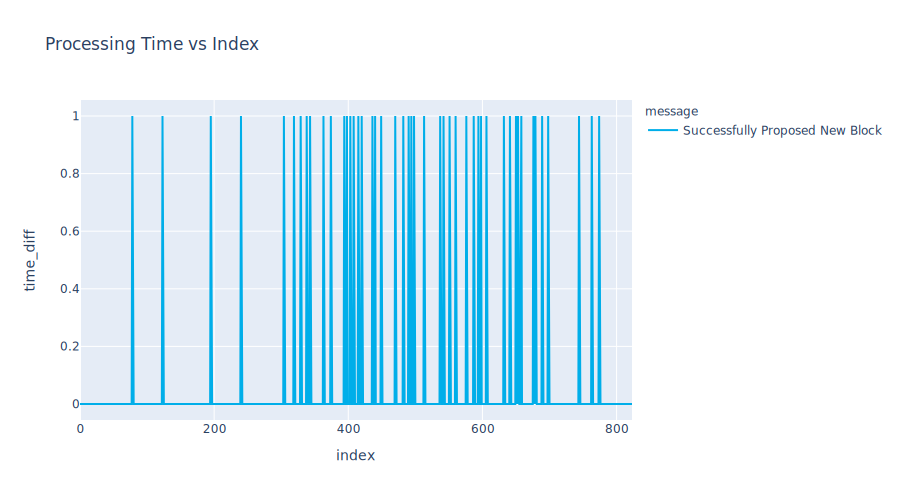

Total duplicate percentage for blockchain 1: 0.16
Total duplicates of pairs percentage for blockchain 1: 0.0
Total duplicates of 'proposing new block' only percentage for blockchain 1: 0.16


/Users/yishuang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/yishuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



png graphs saved in ../../graphs/processing_time/index/png/


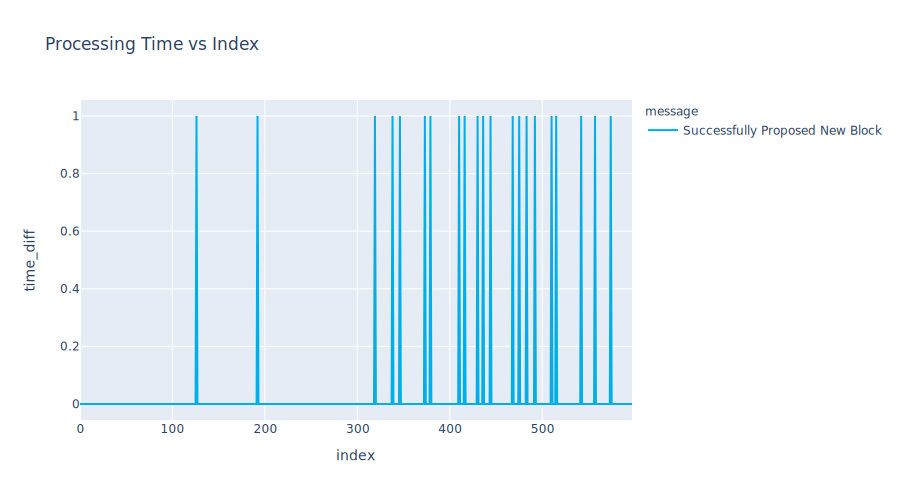

Total duplicate percentage for blockchain 2: 6.137416761285175e-05
Total duplicates of pairs percentage for blockchain 2: 0.0
Total duplicates of 'proposing new block' only percentage for blockchain 2: 6.137416761285175e-05
png graphs saved in ../../graphs/processing_time/index/png/


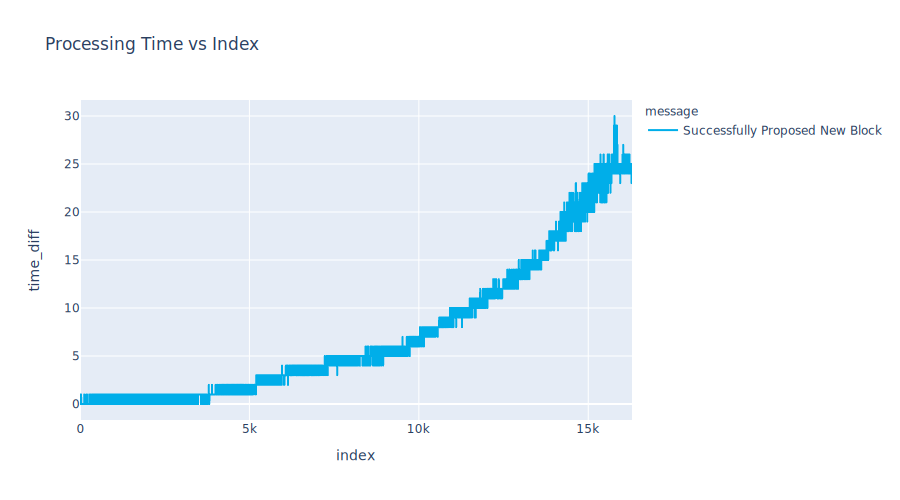

Total duplicate percentage for blockchain 3: 0.0
Total duplicates of pairs percentage for blockchain 3: 0.0
Total duplicates of 'proposing new block' only percentage for blockchain 3: 0.0
png graphs saved in ../../graphs/processing_time/index/png/


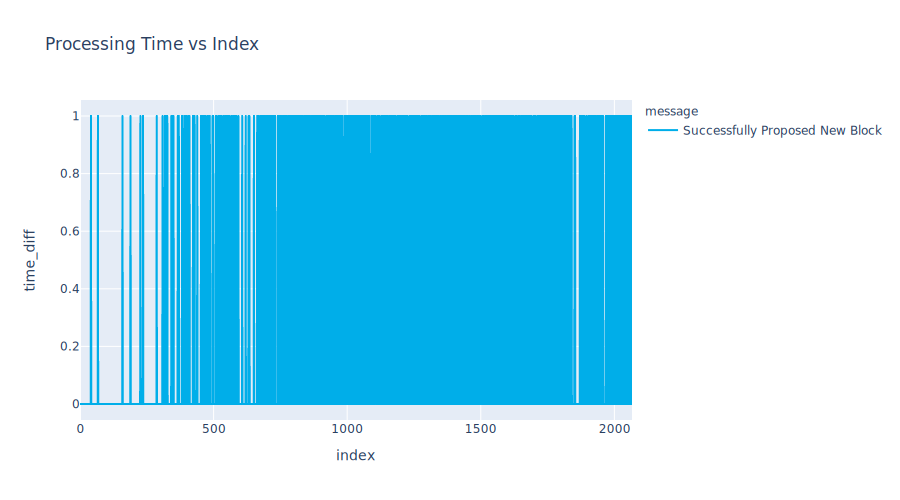

Total duplicate percentage for blockchain 4: 0.0008278145695364238
Total duplicates of pairs percentage for blockchain 4: 0.0008278145695364238
Total duplicates of 'proposing new block' only percentage for blockchain 4: 0.0
png graphs saved in ../../graphs/processing_time/index/png/


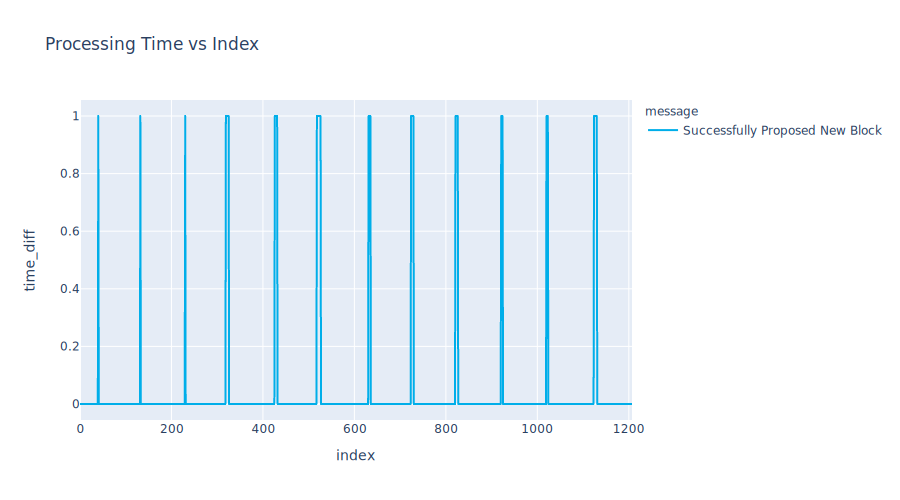

Total duplicate percentage for blockchain 5: 0.0
Total duplicates of pairs percentage for blockchain 5: 0.0
Total duplicates of 'proposing new block' only percentage for blockchain 5: 0.0
png graphs saved in ../../graphs/processing_time/index/png/


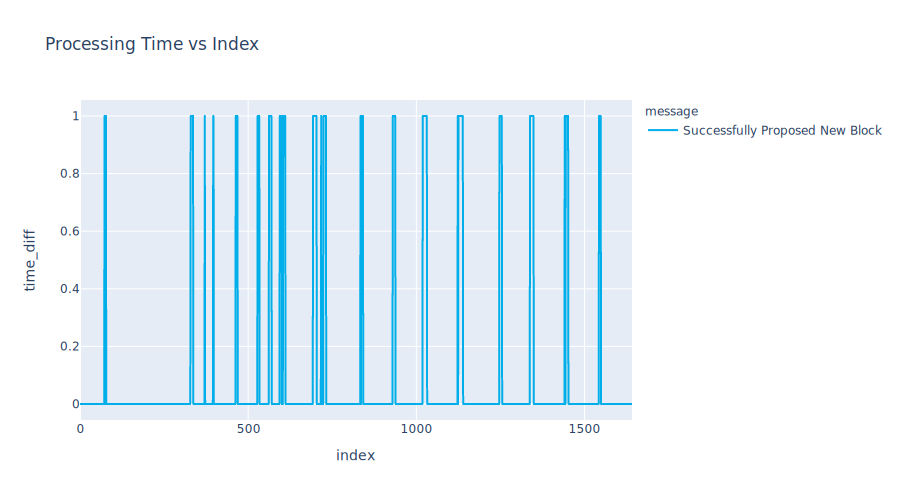

Total duplicate percentage for blockchain 6: 0.0
Total duplicates of pairs percentage for blockchain 6: 0.0
Total duplicates of 'proposing new block' only percentage for blockchain 6: 0.0
png graphs saved in ../../graphs/processing_time/index/png/


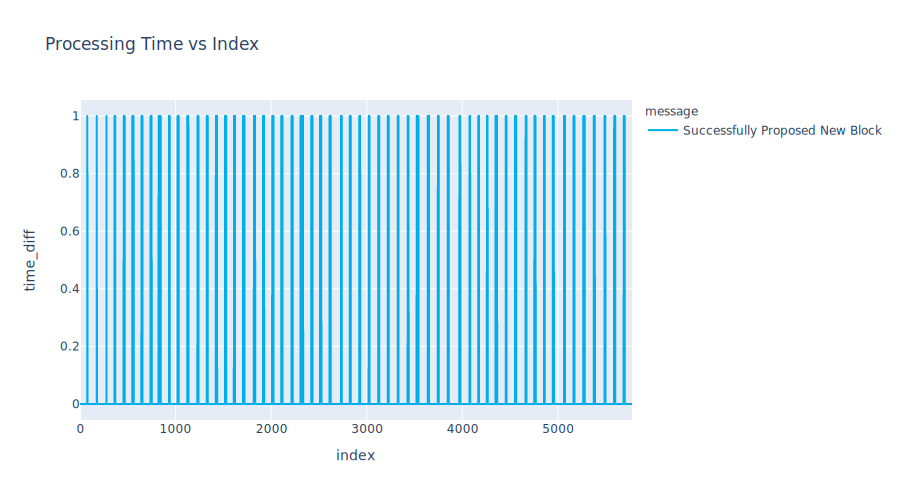

Total duplicate percentage for blockchain 7: 0.0
Total duplicates of pairs percentage for blockchain 7: 0.0
Total duplicates of 'proposing new block' only percentage for blockchain 7: 0.0
png graphs saved in ../../graphs/processing_time/index/png/


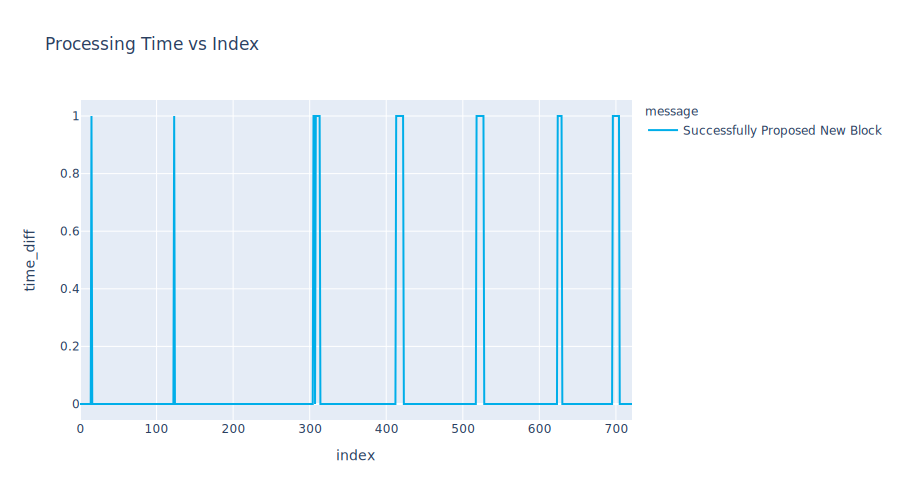

Total duplicate percentage for blockchain 8: 0.0
Total duplicates of pairs percentage for blockchain 8: 0.0
Total duplicates of 'proposing new block' only percentage for blockchain 8: 0.0
png graphs saved in ../../graphs/processing_time/index/png/


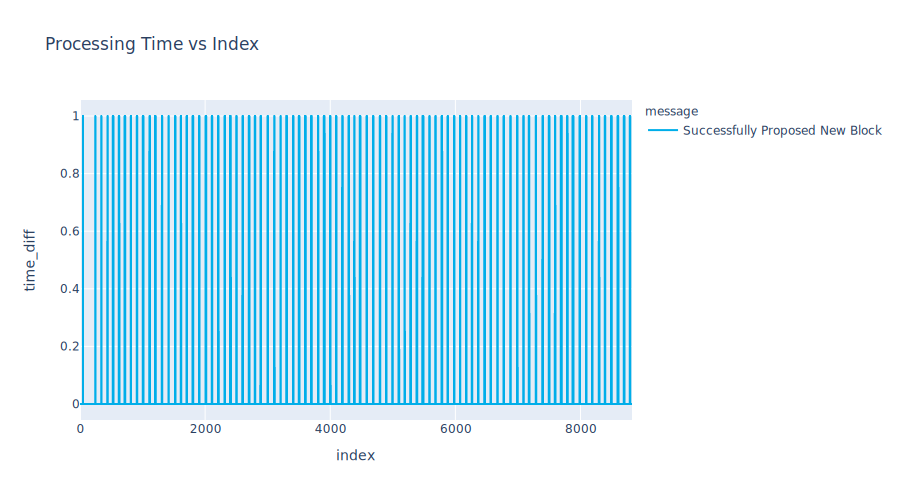

In [21]:
dup, pair_dup, only_dup = 0, 0, 0
for idx in range(len(index)-1):
    new = df.loc[index[idx]:index[idx+1]-1]
    new.reset_index(inplace = True, drop = True) 
    
    message = new.groupby(['blockNum', 'message'])['time'].count().unstack(fill_value=0)
    
    # calculate different types of duplicates
    duplicate, pair, only = print_duplicates_info(new, message, idx)
    dup += duplicate
    pair_dup += pair
    only_dup += only
    
    # remove extra proposing new block
    message['duplicate'] = message.apply(lambda c: True if c['PROPOSING NEW BLOCK'] == \
                                         c['Successfully Proposed New Block'] else False, axis = 1)
    duplicate = message[message['duplicate'] == False].index.tolist()
    lst = []
    for dup in duplicate:
        keep = set(new[(new['blockNum']==dup) & (new['message'] == "Successfully Proposed New Block")].index)
        lst.extend(set(new[(new['blockNum']==dup)].index) - {i-1 for i in keep}.union(keep))
    new.drop(new.index[lst], inplace=True)

    # calculate the time difference 
    new['time_diff'] = new.groupby(['blockNum'])['time'].apply(lambda c: c.diff().dt.seconds)
    new = new[new['message'] == 'Successfully Proposed New Block']
    new.reset_index(inplace = True, drop = True) 
    
    # draw graphs
    draw_graph_index(new, fig_dir, idx)

In [23]:
print("total duplicate percentage: " + str(dup/len(df)))
print("total pair duplicate percentage: " + str(pair_dup/len(df)))
print("total proposing only duplicate percentage: " + str(only_dup/len(df)))

total duplicate percentage: 0.11132415828844626
total pair duplicate percentage: 5.0458542000428897e-05
total proposing only duplicate percentage: 0.04239778991586038
